In [1]:
import pandas as pd
import numpy as np
from nltk import ngrams
import nltk
import sys
#!{sys.executable} -m pip install textblob
from textblob import TextBlob
#!{sys.executable} -m pip install wordcloud
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sqlite3 as sql
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
import requests
#!{sys.executable} -m pip install bs4
from bs4 import BeautifulSoup
#!{sys.executable} -m pip install wordcloud
import re
#!{sys.executable} -m pip install unidecode
import unidecode

## Import a database of items to recognise as food and reviews

In [2]:
# A list of food descriptions from the US food groups
read_des = pd.read_csv('sr27asc/FOOD_DES.txt', sep = "^")
read_des['shortdes'] = read_des['shortdes'].str.replace('~', '', regex = True)
food_list = read_des['shortdes'].values

food_list2 = []
for food in food_list:
    items = food.split(',')
    food_list2.append(items[0])
    
food_list2  = set(food_list2)
food_list2

{'ALMOND PASTE',
 'CHEESECAKE COMMLY PREP',
 'AUSTIN',
 "CAMPBELL'S PORK & BNS",
 "CAMPBELL'S RED & WHITE - MCRWVEABLE BOWLS",
 'TURBOT',
 'BLACKBERRY JUC',
 'LEMON GRASS (CITRONELLA)',
 'PEANUT BUTTER W/ OMEGA-3',
 'BEERWURST  PORK & BF',
 'SEAL',
 'SUPPER MEAL KITS',
 'FRANCO-AMERICAN SLOW RST CHICK GRAVY',
 'COFFEECAKE',
 'PIZZA HUT 14" SAUSAGE PIZZA',
 'CHOKECHERRIES',
 'CELERIAC',
 'OAT BRAN',
 'SWEETENERS',
 'SESAME FLR',
 'PUFF PASTRY',
 'ANIMAL FAT',
 'LIVERWURST SPRD',
 'TURKEY FROM WHL',
 'BEEF',
 'BISON',
 'BOLOGNA  TURKEY',
 'SAUSAGE  SMMR  PORK & BF  STKS  W/ CHEDDAR CHS',
 'WORTHINGTON FRIPATS',
 'CUMIN SEED',
 'ICE CRM SNDWCH',
 'POTATO SOUP',
 'PILLSBURY',
 'TEMPEH',
 "MORNINGSTAR FARMS ITALIAN HERB CHIK'N PATTIE",
 'FRANCO-AMERICAN SLOW RST BF GRAVY',
 'CRANBERRY JUC COCKTAIL',
 'PEANUTS',
 'WORTHINGTON CHILI',
 'MORNINGSTAR FARMS BRKFST BSCT SAUSAGE',
 'KASHI PESTO PASTA PRIMAVERA',
 'OKARA',
 'HAZELNUTS OR FILBERTS',
 'COUSCOUS',
 'CAROB FLOUR',
 'NATTO',
 'MORNINGST

In [3]:
# Add in foods that are Viet from wiki and unlikely to be in the common foods database
URL = 'https://en.wikipedia.org/wiki/List_of_Vietnamese_dishes'
website_url = requests.get(URL).text
soup = BeautifulSoup(website_url)
tables = soup.find_all('table',{'class':'wikitable sortable'})
viet_food = []

for table in tables:
    links = table.findAll('a')
    for link in links:
        food = link.get('title')
        food = re.sub(r"\(.*\)","",str(food))
        food = unidecode.unidecode(food)
        if food != 'None':
            viet_food.append(food)
    
viet_food = [x.strip(' ') for x in viet_food]
viet_food

excludeloc = ['Province', 'Coast', 'Vietnam', 'Hanoi', 'Delta', 'City', 'Saigon']

viet_food_filtered = []
for food in viet_food:
    add = 1
    for loc in excludeloc:
        if loc in food:
            add = 0
            break
    if add == 1:
        viet_food_filtered.append(food.upper())

viet_food_filtered = set(viet_food_filtered)
viet_food_filtered

{'BALUT',
 'BANH',
 'BANH BA TRANG',
 'BANH BAO',
 'BANH BEO',
 'BANH BO',
 'BANH BOT CHIEN',
 'BANH BOT LOC',
 'BANH BOT LOC LA',
 'BANH BOT LOC TRAN',
 'BANH CAM',
 'BANH CAN',
 'BANH CANH',
 'BANH CAY',
 'BANH CHUNG',
 'BANH CHUOI',
 'BANH CUON',
 'BANH DA',
 'BANH DA LON',
 'BANH DUC',
 'BANH GOI',
 'BANH HOI',
 'BANH IT',
 'BANH IT TRAN',
 'BANH KHOAI MI',
 'BANH KHOT',
 'BANH KHUC',
 'BANH LA',
 'BANH MI',
 'BANH NAM',
 'BANH PHU THE',
 'BANH PHU THE BOT BAN',
 'BANH PIA',
 'BANH RAN',
 'BANH RE',
 'BANH TE',
 'BANH TET',
 'BANH TIEU',
 'BANH TOM',
 'BANH TOM HO TAY',
 'BANH TRANG',
 'BANH TRUNG THU',
 'BANH UOT',
 'BANH XEO',
 'BIA HOI',
 'BINH DINH',
 "BIRD'S EYE CHILI",
 "BIRD'S NEST SOUP",
 'BLACK PUDDING',
 'BO 7 MON',
 'BOLOGNA SAUSAGE',
 'BUN BO HUE',
 'BUN CHA',
 'BUN MANG VIT',
 'BUN OC',
 'BUN RIEU',
 'BUN THIT NUONG',
 'CA MAU',
 'CANH CHUA',
 'CAO LAU',
 'CASSAVA-BASED DISHES',
 'CELLOPHANE NOODLES',
 'CHA',
 'CHA GIO',
 'CHAM CHEO',
 'CHANH MUOI',
 'CHAO TOM',
 'CHAO

In [4]:
#combine all food sets

food_list = food_list2 | viet_food_filtered

In [5]:
reviews = pd.read_csv("../viet_review.csv")
reviews.head()

,review_id,user_id,cool,text,useful,funny,stars,date
0,ydmLJUsQTKrUMmM1hSFjFg,LPva2snYp0Fdu8Z1QIXLiA,0,What can I say? The bread is made daily and t...,1,0,4,2018-02-01 19:18:02
1,eDBC5o8_28FMafDAeT1lJQ,omzXdnZFmB6irpf7jmTQWQ,0,I love the atmosphere ! Perfect for families !...,1,1,5,2016-05-19 05:03:48
2,Nr5hefDW-Yitb3jYgmL2UA,k1zNCz3JODi3YN5sXcKApw,0,My family and I love this place. The food came...,0,0,5,2017-05-13 08:56:04
3,h0WIzX3KjDB4LeIhLQ3bvw,ea-FFbghzx-nm4YZthLJaw,0,Came here on a Saturday for dinner.. there was...,1,0,5,2017-04-30 04:05:21
4,UcBJrncwfqj63u-z1E8Flw,lgh7a1Qey0bbmv5JIQ1beQ,2,So far one of the best customer service I have...,2,1,5,2014-04-01 06:22:54


In [37]:
good = [1 if i > 3 else 0 for i in reviews['stars']]
reviews['date'] = pd.to_datetime(reviews['date'])
year = reviews['date'].dt.year
text  = reviews['text']
year_good = pd.DataFrame(year)
year_good['good'] = good
year_good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108484 entries, 0 to 108483
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   date    108484 non-null  int64
 1   good    108484 non-null  int64
dtypes: int64(2)
memory usage: 1.7 MB


## Create a functions to extract foods

In [7]:
def is_food(word):
    result = word.upper() in food_list
    return result

In [39]:
def food_mention(textlist):
    EXCLUSIONS = ['vietnamese', 'restaurant', 'spot']
    #initiate the columns I want to make
    index_fm = ""
    food_mention = ""

    for review_idx, val in tqdm(enumerate(textlist)):
        blob = TextBlob(val.lower())
        for word_idx, (word, tag) in enumerate(blob.tags[1:(len(blob.tags)-1)], start = 1):
            if is_food(word) and word.lower() not in EXCLUSIONS:
                appended = 0
                if blob.tags[word_idx+1][1].startswith("NN"):
                    phrase1 = word.lower() + "_" + blob.tags[word_idx+1][0].lower()
                    food_mention += word + " "
                    index_fm += str(review_idx) + " "
                    appended = 1
                if blob.tags[word_idx-1][1].startswith("JJ") or blob.tags[word_idx-1][1].startswith("NN"):
                    phrase2 = blob.tags[word_idx-1][0].lower() + "_"  + word.lower() 
                    food_mention += phrase2 + " "
                    index_fm += str(review_idx) + " "
                    appended = 1
                if appended == 0:
                    food_mention += word.lower() + " "
                    index_fm += str(review_idx) + " "
    frame = {'index_fm': pd.Series(index_fm.split()),'food_mention': pd.Series(food_mention.split())}
    results = pd.DataFrame(frame)
    results['index_fm'] = pd.to_numeric(results['index_fm'])
    return results

In [33]:
def combine_list(results):
    food_trend = results.merge(year_good, how = 'left', left_on='index_fm', right_index = True)
    food_trend = food_trend.drop_duplicates()
    return food_trend

In [30]:
def process_trend(food_trend):
    #take out 'single' words that are already represented in double words
    #extract single words
    singles = []

    for food in food_trend.food_mention:
        if '_' not in food:
            singles.append(food)

    singles = set(singles)

    singles_to_del = []

    for single in singles:
        for food in food_trend.food_mention:
            if '_' in food:
                if single in food:
                    singles_to_del.append(single)

    singles_to_del = set(singles_to_del)

    food_trend_processed = food_trend[~food_trend['food_mention'].isin(singles_to_del)]

    return food_trend_processed

In [31]:
def extract_food_mention(textlist):
    results = food_mention(textlist)
    combinedlist = combine_list(results)
    food_trend_processed = process_trend(combinedlist)
    return food_trend_processed

In [42]:
food_trend_reviews = extract_food_mention(text)
food_trend_reviews.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 209766 entries, 3 to 548358
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index_fm      209766 non-null  int64 
 1   food_mention  209766 non-null  object
 2   date          209766 non-null  int64 
 3   good          209766 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 8.0+ MB


In [58]:
food_trend_reviews[food_trend_reviews.food_mention == 'lobster_pho']

,index_fm,food_mention,date,good
231,45,lobster_pho,2018,1
425,79,lobster_pho,2017,1
955,185,lobster_pho,2015,1
979,195,lobster_pho,2015,1
1159,227,lobster_pho,2015,1
...,...,...,...,...
534583,105906,lobster_pho,2019,1
535614,106087,lobster_pho,2019,1
535641,106089,lobster_pho,2018,1
537991,106520,lobster_pho,2019,0


In [66]:
reviews.iloc[227,:]

review_id                               uozxNAtDHffqXO0GtR-dCQ
user_id                                 Mho2GibREwsPesKEyQbt8w
cool                                                         7
text         Initially I was going to try Pho Basa last wee...
useful                                                       7
funny                                                        5
stars                                                        5
date                                       2015-04-15 17:51:17
Name: 227, dtype: object

In [117]:
# combine descriptions of pho that aren't food related 

#idx_to_extract = []
#for idx, food in enumerate(food_trend.food_mention):
    #if 'pho' not in food:
    #    idx_to_extract.append(idx)
   # else:
 #       words = food.split('_')
  #      if is_food(words[0]):
 #           idx_to_extract.append(idx)
        
#replace_pho = []

#for idx, food in enumerate(food_trend.food_mention):
 #   if 'pho' in food:
  #      words = food.split('_')
   #     if not is_food(words[0]):
    #        replace_pho.append(food)
            
#food_trend_processed = food_trend
#food_trend_processed['food_mention'] = food_trend_processed['food_mention'].replace(replace_pho, 'pho')
#food_trend_processed['food_mention'] = food_trend_processed['food_mention'].str.lower()

In [43]:
food_trend_reviews.to_csv('food_trend_final.csv')

## Word cloud of food mentions

In [44]:
def all_good_bad_values(all_food_mention):
    # split good and bad
    food_trend_filtered_good = all_food_mention[all_food_mention.good == 1.0]
    food_trend_filtered_bad = all_food_mention[all_food_mention.good == 0.0]
    
    food_mention_all = ' '.join(all_food_mention.food_mention.values.tolist())
    food_mention_good = ' '.join(food_trend_filtered_good.food_mention.values.tolist())
    food_mention_bad = ' '.join(food_trend_filtered_bad.food_mention.values.tolist())
    
    return food_mention_all, food_mention_good, food_mention_bad

def create_wc(foodmentionstrings):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(foodmentionstrings) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

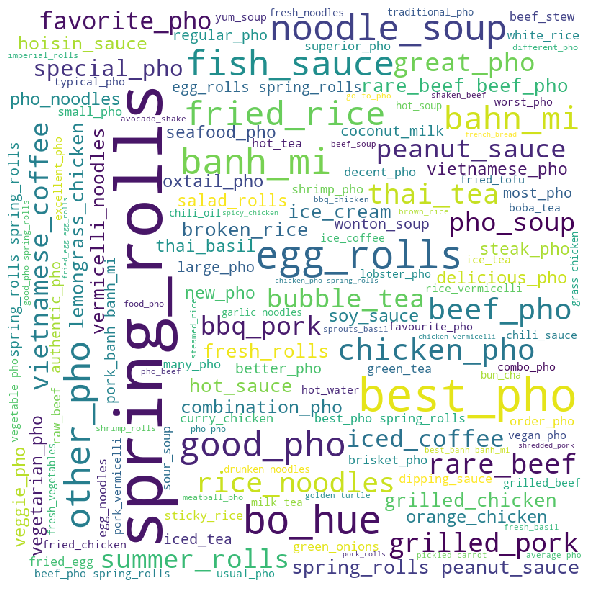

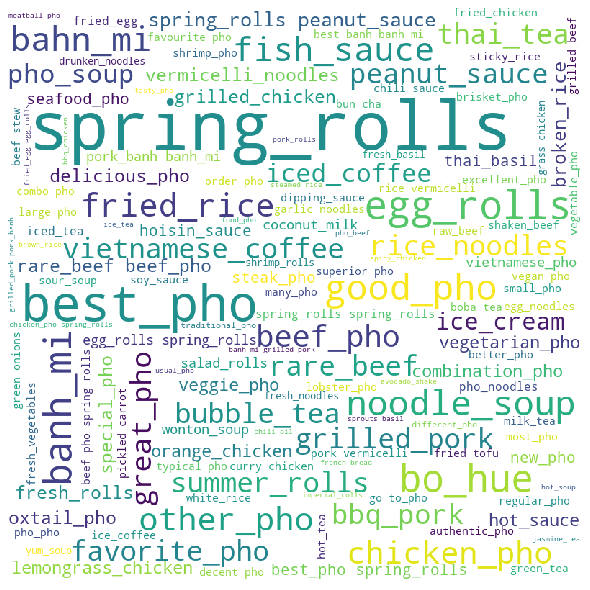

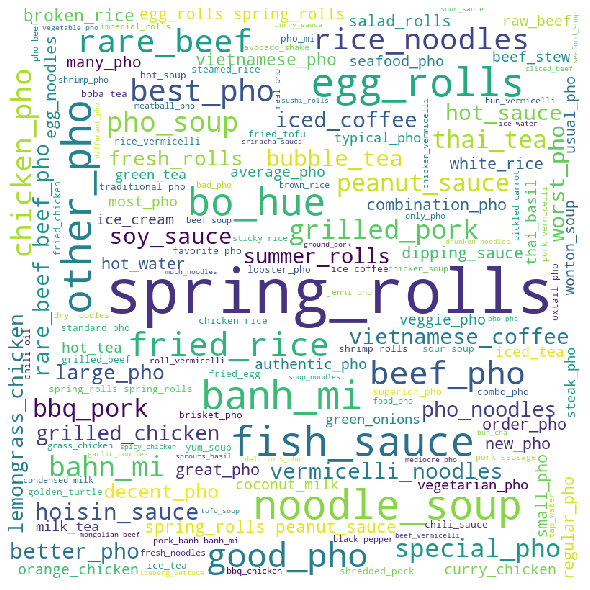

In [45]:
fm_all, fm_good, fm_bad = all_good_bad_values(food_trend_reviews)

for i in ([fm_all, fm_good, fm_bad]):
    create_wc(i)

## do it for tips

In [46]:
tips = pd.read_csv("../tip_vietnamese.csv")
tips_text  = tips['text']
tips_date = tips

tips['date'] = pd.to_datetime(tips['date'])
tips_year = tips['date'].dt.year

In [47]:
tips_fm = food_mention(tips_text)

KeyError: 'index_fm'

In [48]:
tips_fm = tips_fm.merge(tips_year, how = 'left', left_on = 'index_fm', right_index = True)
tips_fm_processed = process_trend(tips_fm)
tips_fm_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7938 entries, 1 to 15832
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index_fm      7938 non-null   int64 
 1   food_mention  7938 non-null   object
 2   date          7938 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 248.1+ KB


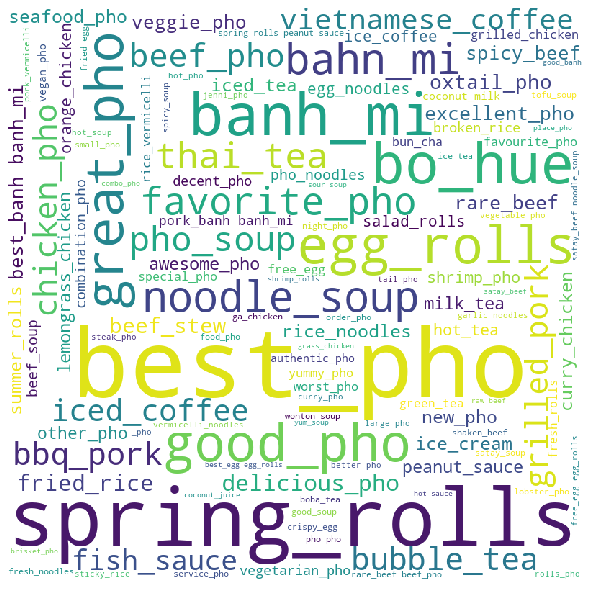

In [52]:
create_wc(' '.join(tips_fm_processed.food_mention.values.tolist()))

In [54]:
tips_fm_processed.to_csv('food_tip_final.csv')